# EN3160 – Assignment 1  
## *Intensity Transformations & Neighborhood Filtering*

---

**Name:** *Rathnayake R.M.T.N.B.*  
**Index Number:** *220528X*  
**Date:** 2025-08-12  
**Course Instructor:** Dr. Ranga Rodrigo  

---

> *This notebook contains implementations, results, and brief discussions for each question in the assignment. Code cells are self-contained so each question can be run independently. Plots and images are generated inline for clarity.*

---


In [54]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os

### Question 1 – Intensity Transformation

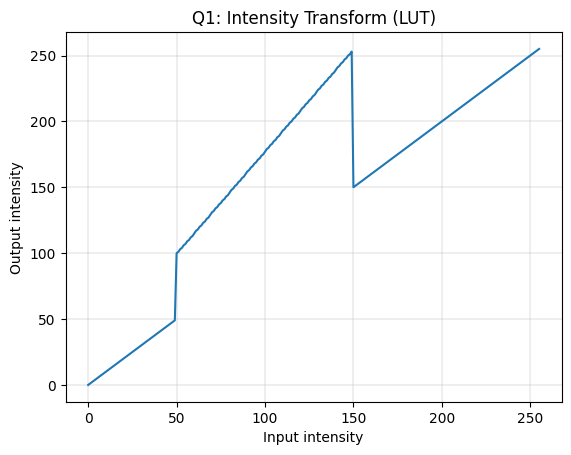

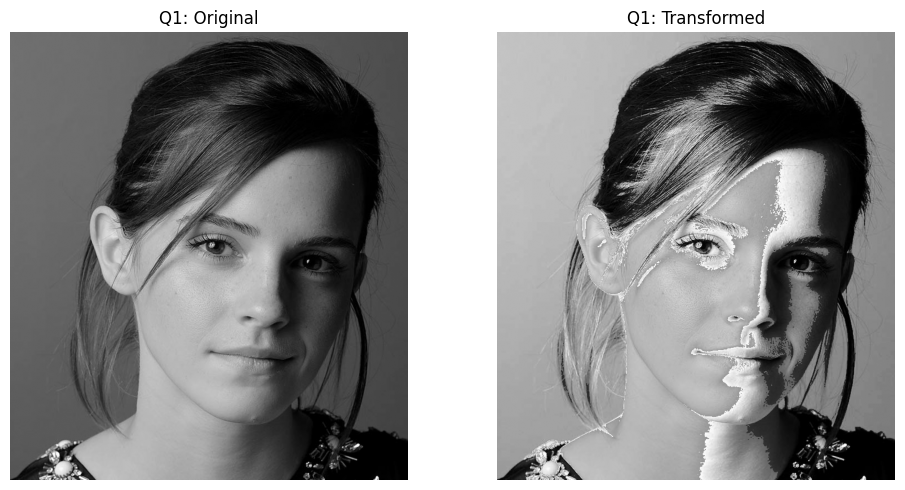

True

In [55]:
def imread_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: raise FileNotFoundError(path)
    return img

def show_gray(img1, img2, title1="Original", title2="Transformed"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1, cmap='gray', vmin=0, vmax=255)
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(img2, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Fig. 1a piecewise mapping as a LUT ---
def build_q1_lut():
    xs = np.arange(256, dtype=np.float32)
    y  = np.zeros_like(xs)

    # 0..49 : y = x
    y[0:50] = xs[0:50]

    # 50..149 : line through (50,100) -> (150,255)
    # slope = (255-100)/(150-50) = 155/100 = 1.55
    y[50:150] = 100 + 1.55*(xs[50:150] - 50)

    # x = 150 : force the drop to 150 (discontinuity)
    y[150] = 150

    # 151..255 : line through (150,150) -> (255,255)  => y = x
    y[151:256] = xs[151:256]

    return np.clip(y, 0, 255).astype(np.uint8)

# --- apply ---
img_path = "./a1images/emma.jpg"
img      = imread_gray(img_path)
lut      = build_q1_lut()
out      = cv2.LUT(img, lut)

# --- show & save ---
plt.figure(); plt.plot(np.arange(256), lut)
plt.title("Q1: Intensity Transform (LUT)")
plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True, linewidth=0.3); plt.show()

show_gray(img, out, "Q1: Original", "Q1: Transformed")

cv2.imwrite("./Output_Images/q1_output.png", out)


### Question 2 – Accentuate white vs gray matter

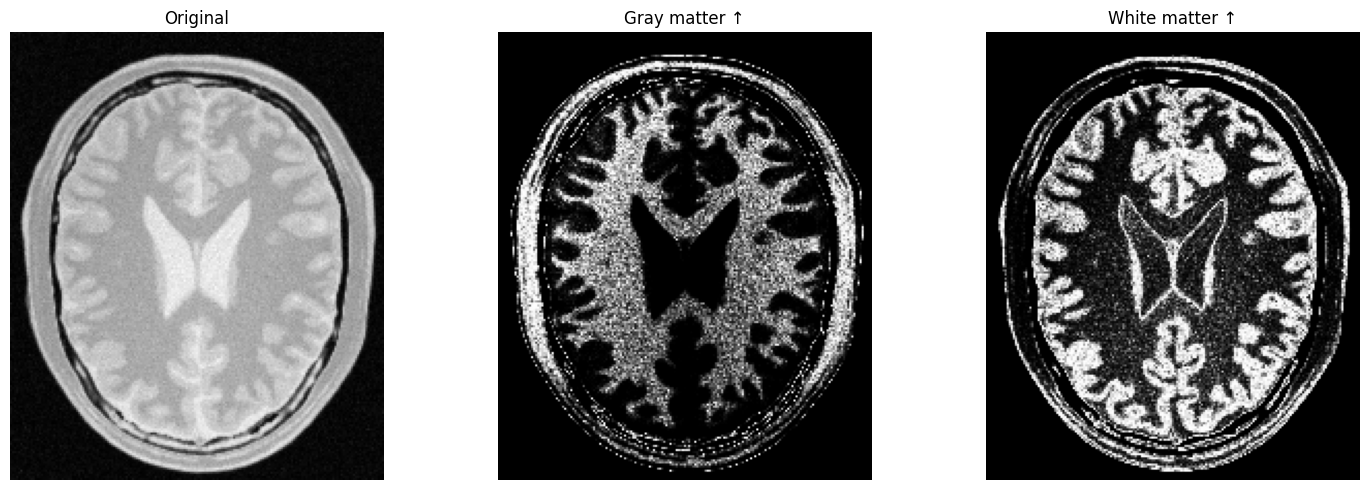

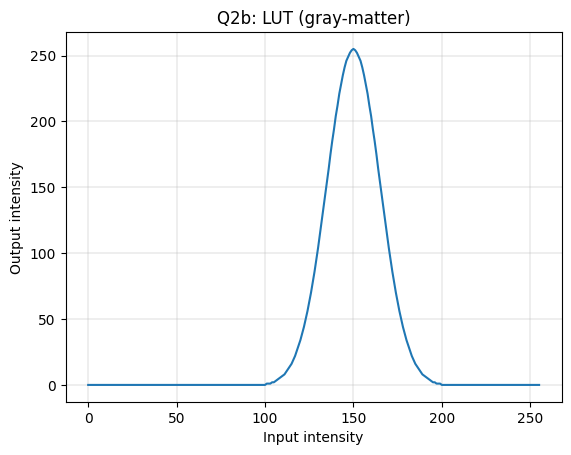

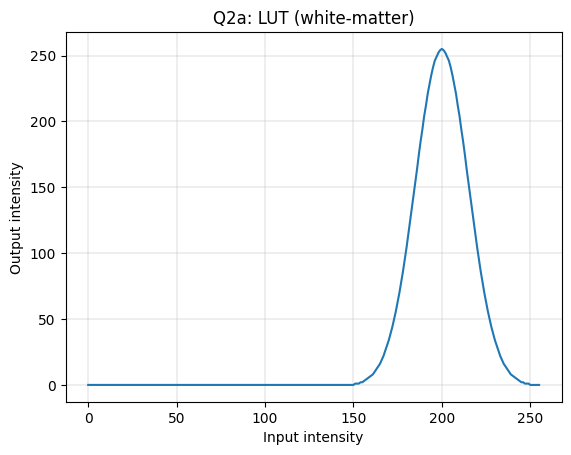

True

In [56]:
import cv2, numpy as np, matplotlib.pyplot as plt

def gaussian_lut(mu, sigma, A=255, b=0, mode="pure", a=0.8):
    """
    mode:
      'pure' -> y = b + A * G(x)                 (band-pass; outside band -> near b)
      'add'  -> y = x + a * (A * G(x))/2         (identity + bump; mostly monotonic)
      'mul'  -> y = x * (1 + a * G(x))           (gain around mu; monotonic)
    """
    x  = np.arange(256, dtype=np.float32)
    G  = np.exp(-((x - mu)**2) / (2.0 * sigma**2))  # 0..1

    if mode == "pure":
        y = b + A * G
    elif mode == "add":
        y = x + a * (A * G) / 2.0
    else:  # 'mul'
        y = x * (1.0 + a * G)

    return np.clip(y, 0, 255).astype(np.uint8)

def show_gray_row(imgs, titles):
    n = len(imgs)
    fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
    if n == 1: ax = [ax]
    for a, im, t in zip(ax, imgs, titles):
        a.imshow(im, cmap='gray', vmin=0, vmax=255); a.set_title(t); a.axis('off')
    plt.tight_layout(); plt.show()

# --- load brain image ---
brain = cv2.imread("./a1images/brain_proton_density_slice.png", cv2.IMREAD_GRAYSCALE)

# ---- Choose parameters (tune by histogram) ----
gm_mu, gm_sigma = 150, 15
wm_mu, wm_sigma = 200, 15

# --- Use PURE Gaussian for tight band-pass ---
gm_lut = gaussian_lut(gm_mu, gm_sigma, A=255, b=0, mode="pure")
wm_lut = gaussian_lut(wm_mu, wm_sigma, A=255, b=0, mode="pure")

gm_img = cv2.LUT(brain, gm_lut)
wm_img = cv2.LUT(brain, wm_lut)

show_gray_row([brain, gm_img, wm_img], ["Original", "Gray matter ↑", "White matter ↑"])

# --- Plot the transforms (required in question) ---
for ttl, lut in [("Q2b: LUT (gray-matter)", gm_lut), ("Q2a: LUT (white-matter)", wm_lut)]:
    plt.figure(); plt.plot(lut); plt.title(ttl)
    plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True, linewidth=0.3); plt.show()

cv2.imwrite("./Output_Images/q2_gray.png",  gm_img)
cv2.imwrite("./Output_Images/q2_white.png", wm_img)

### Question 3 - Gamma on the L channel 

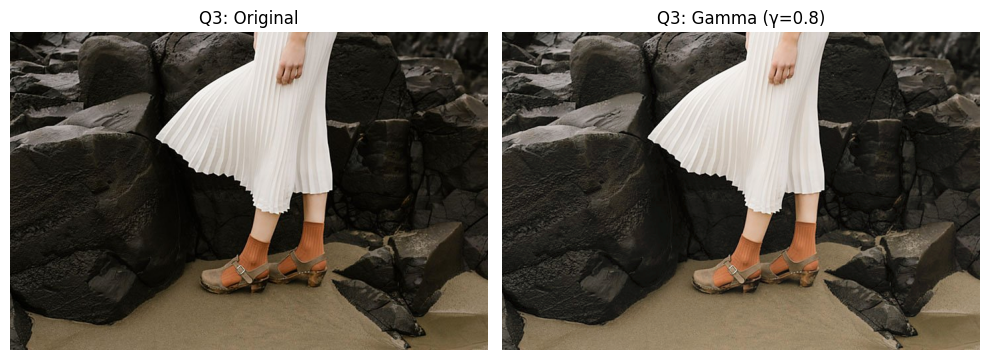

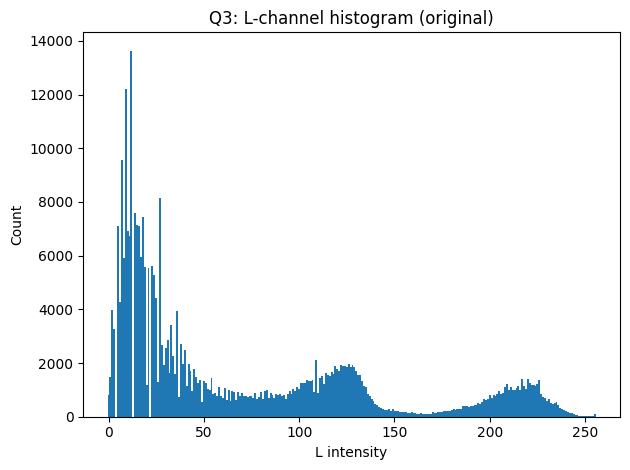

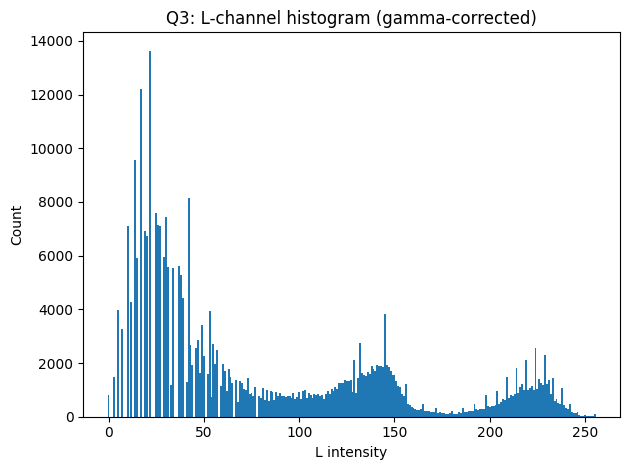

In [57]:
def show_color_side_by_side(img1_bgr, img2_bgr, t1="Original", t2="Gamma corrected"):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)); ax[0].set_title(t1); ax[0].axis('off')
    ax[1].imshow(cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)); ax[1].set_title(t2); ax[1].axis('off')
    plt.tight_layout(); plt.show()

def plot_hist_L(L, title):
    h = cv2.calcHist([L],[0],None,[256],[0,256]).ravel()
    plt.figure(); plt.bar(np.arange(256), h, width=1.0)
    plt.title(title); plt.xlabel("L intensity"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# --- load image (Fig. 3) ---
img_path = "./a1images/highlights_and_shadows.jpg"   
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
assert img is not None, "Check q3 image path"

# --- gamma on L only ---
gamma = 0.8   
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L, a, b = cv2.split(lab)

Lf = L.astype(np.float32) / 255.0
Lg = np.power(Lf, gamma)
L_corr = np.clip(Lg * 255.0, 0, 255).astype(np.uint8)

lab_corr = cv2.merge([L_corr, a, b])
img_corr = cv2.cvtColor(lab_corr, cv2.COLOR_LAB2BGR)

# --- visuals ---
show_color_side_by_side(img, img_corr, "Q3: Original", f"Q3: Gamma (γ={gamma})")
plot_hist_L(L,      "Q3: L-channel histogram (original)")
plot_hist_L(L_corr, "Q3: L-channel histogram (gamma-corrected)")

# --- save outputs for report ---
os.makedirs("./Output_Images", exist_ok=True)
cv2.imwrite("./Output_Images/q3_gamma_corrected.png", img_corr)

# save histogram figures too
for arr, ttl, fname in [
    (L,      "Q3_L_hist_original",       "q3_L_hist_original.png"),
    (L_corr, f"Q3_L_hist_gamma_{gamma}", f"q3_L_hist_gamma_{gamma}.png"),
]:
    h = cv2.calcHist([arr],[0],None,[256],[0,256]).ravel()
    fig, ax = plt.subplots()
    ax.bar(np.arange(256), h, width=1.0)
    ax.set_title(ttl); ax.set_xlabel("L intensity"); ax.set_ylabel("Count")
    fig.savefig(f"./Output_Images/{fname}", dpi=200, bbox_inches="tight"); plt.close(fig)


### Question 4 - Vibrance via saturation transform (HSV)

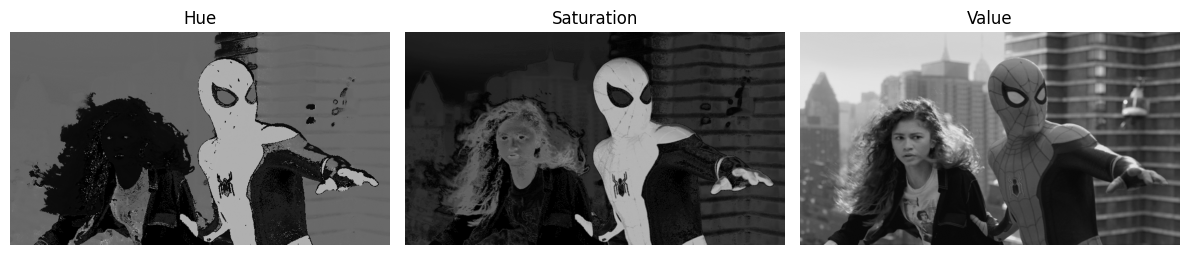

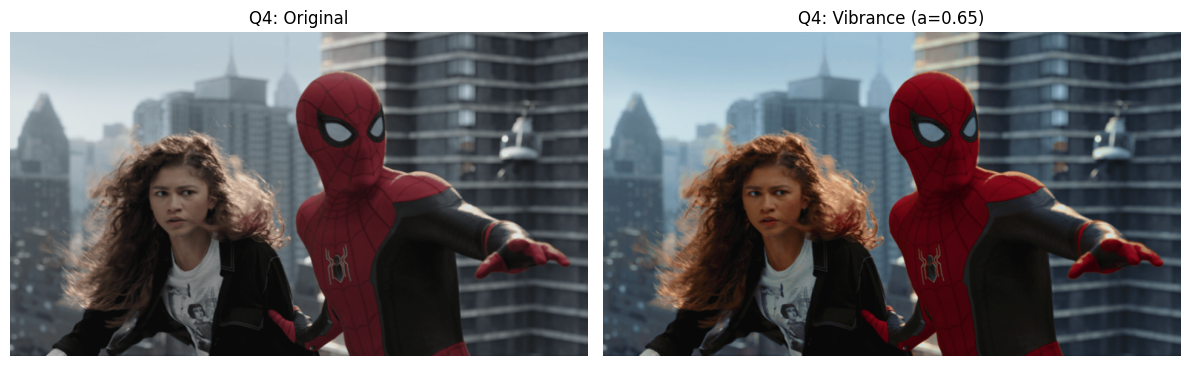

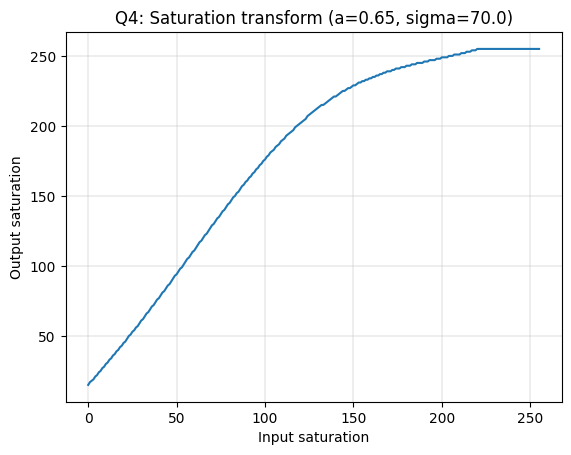

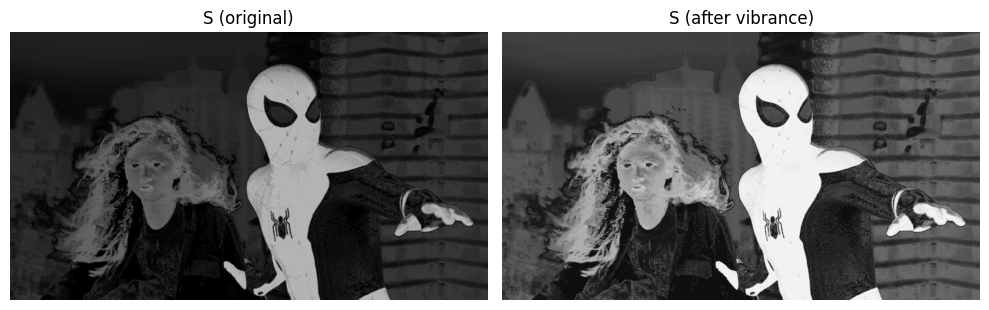

In [58]:
def show_color_side_by_side(img1_bgr, img2_bgr, t1="Original", t2="Vibrance +"):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].imshow(cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)); ax[0].set_title(t1); ax[0].axis('off')
    ax[1].imshow(cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)); ax[1].set_title(t2); ax[1].axis('off')
    plt.tight_layout(); plt.show()

def show_hsv_planes(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    for a, plane, title in zip(ax, [h,s,v], ["Hue", "Saturation", "Value"]):
        a.imshow(plane, cmap='gray', vmin=0, vmax=255); a.set_title(title); a.axis('off')
    plt.tight_layout(); plt.show()

def vibrance_lut(a=0.6, sigma=70.0):
    x = np.arange(256, dtype=np.float32)
    bump = 128.0 * np.exp(-((x - 128.0)**2) / (2.0 * (sigma**2)))  # centered @ mid-saturation
    y = x + a * bump
    return np.clip(y, 0, 255).astype(np.uint8)

def apply_vibrance(img_bgr, a=0.6, sigma=70.0):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lut = vibrance_lut(a=a, sigma=sigma)
    s2 = cv2.LUT(s, lut)
    out = cv2.cvtColor(cv2.merge([h, s2, v]), cv2.COLOR_HSV2BGR)
    return out, lut, (h,s,v), s2

# --- load Figure 4 image ---
img_path = "./a1images/spider.png"   # <-- set this path
img = cv2.imread(img_path); assert img is not None, "Check Q4 image path"

# (a) show H/S/V planes
show_hsv_planes(img)

# (b)(c)(d) apply transform on S, tune 'a' visually
a = 0.65          # <--- adjust until it looks good; report this value
sigma = 70.0
out, lut, (H,S,V), S2 = apply_vibrance(img, a=a, sigma=sigma)

# (e) display originals and result
show_color_side_by_side(img, out, "Q4: Original", f"Q4: Vibrance (a={a})")

# plot the intensity transform
plt.figure(); plt.plot(lut)
plt.title(f"Q4: Saturation transform (a={a}, sigma={sigma})")
plt.xlabel("Input saturation"); plt.ylabel("Output saturation"); plt.grid(True, linewidth=0.3); plt.show()

# optional: show S before/after
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(S,  cmap='gray', vmin=0, vmax=255); ax[0].set_title("S (original)"); ax[0].axis('off')
ax[1].imshow(S2, cmap='gray', vmin=0, vmax=255); ax[1].set_title("S (after vibrance)"); ax[1].axis('off')
plt.tight_layout(); plt.show()

# save outputs for report
os.makedirs("./Output_Images", exist_ok=True)
cv2.imwrite("./Output_Images/q4_vibrance_enhanced.png", out)

fig, ax = plt.subplots()
ax.plot(lut); ax.set_title(f"Q4 LUT (a={a}, sigma={sigma})")
ax.set_xlabel("Input S"); ax.set_ylabel("Output S"); ax.grid(True, linewidth=0.3)
fig.savefig("./Output_Images/q4_vibrance_lut.png", dpi=200, bbox_inches="tight"); plt.close(fig)


### Question 5 - Histogram equalization 

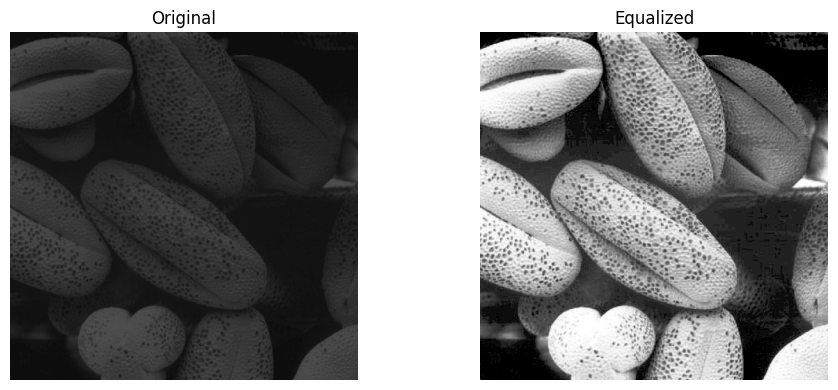

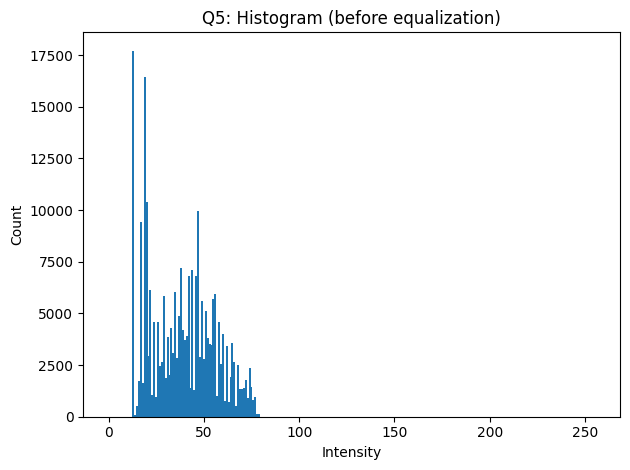

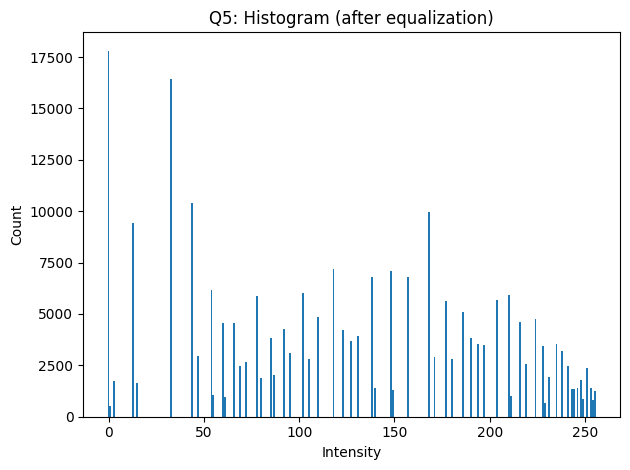

In [68]:
# ---------- core equalization ----------
def hist_equalize_gray(img: np.ndarray):
    """
    Custom histogram equalization for a uint8 grayscale image.
    Returns: equalized image, hist_before, hist_after, lut
    """
    if img.ndim != 2 or img.dtype != np.uint8:
        raise ValueError("Provide a 2D uint8 grayscale image")

    hist = np.bincount(img.ravel(), minlength=256).astype(np.int64)
    cdf  = hist.cumsum()

    nz = np.flatnonzero(cdf)
    if nz.size == 0:  # empty image
        return img.copy(), hist, hist.copy(), np.arange(256, dtype=np.uint8)

    cdf_min = cdf[nz[0]]
    total   = cdf[-1]
    if total == cdf_min:  # flat image
        return img.copy(), hist, hist.copy(), np.arange(256, dtype=np.uint8)

    lut = np.round((cdf - cdf_min) / (total - cdf_min) * 255.0)
    lut = np.clip(lut, 0, 255).astype(np.uint8)

    out = lut[img]
    hist_after = np.bincount(out.ravel(), minlength=256).astype(np.int64)
    return out, hist, hist_after, lut

# ---------- helpers: show + save ----------
def show_and_save_images(orig_u8, eq_u8, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    # display side-by-side
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(orig_u8, cmap="gray", vmin=0, vmax=255); ax[0].set_title("Original");  ax[0].axis("off")
    ax[1].imshow(eq_u8,   cmap="gray", vmin=0, vmax=255); ax[1].set_title("Equalized"); ax[1].axis("off")
    plt.tight_layout(); plt.show()
    # save individual images and the side-by-side figure
    cv2.imwrite(f"{out_dir}/q5_original_gray.png", orig_u8)
    cv2.imwrite(f"{out_dir}/q5_equalized.png",    eq_u8)
    fig.savefig(f"{out_dir}/q5_side_by_side.png", dpi=200, bbox_inches="tight")
    plt.close(fig)

def show_and_save_hist(img_u8, title, savepath):
    h = np.bincount(img_u8.ravel(), minlength=256)
    xs = np.arange(256)
    fig, ax = plt.subplots()
    ax.bar(xs, h, width=1.0)
    ax.set_title(title); ax.set_xlabel("Intensity"); ax.set_ylabel("Count")
    fig.tight_layout()
    plt.show()
    fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.close(fig)

# ---------- run Q5 ----------
src_path = "./a1images/shells.tif"   # <-- set to your Fig.5 path
out_dir  = "./Output_Images"

img = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
assert img is not None, f"Missing image: {src_path}"

# ensure grayscale uint8 (handles color / 16-bit TIF)
if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
if img.dtype != np.uint8:
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

eq, h_before, h_after, lut = hist_equalize_gray(img)

# show + save images
show_and_save_images(img, eq, out_dir)

# show + save histograms (before/after)
show_and_save_hist(img, "Q5: Histogram (before equalization)", f"{out_dir}/q5_hist_before.png")
show_and_save_hist(eq,  "Q5: Histogram (after equalization)",  f"{out_dir}/q5_hist_after.png")


### Question 6 - Foreground-only histogram equalization

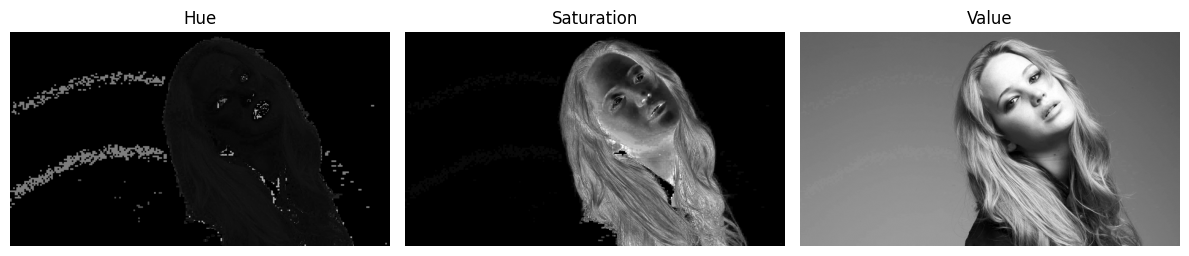

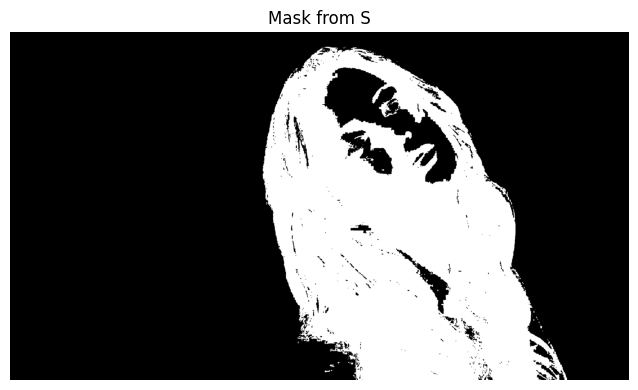

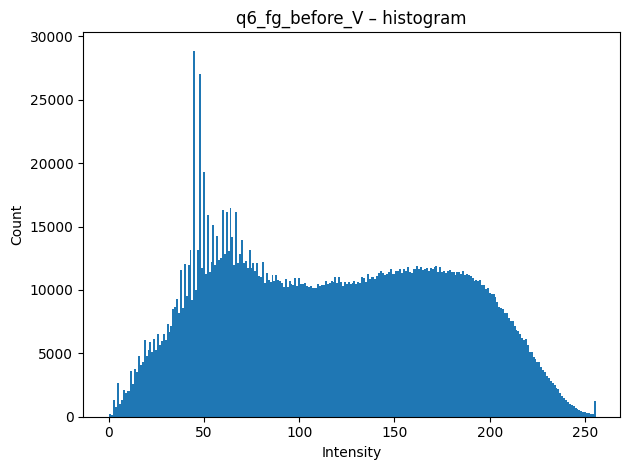

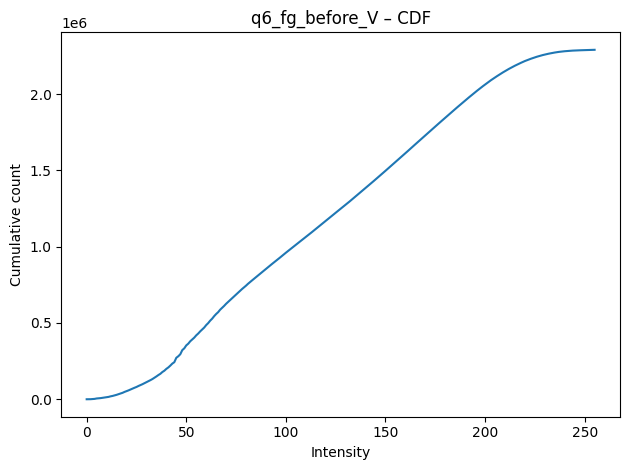

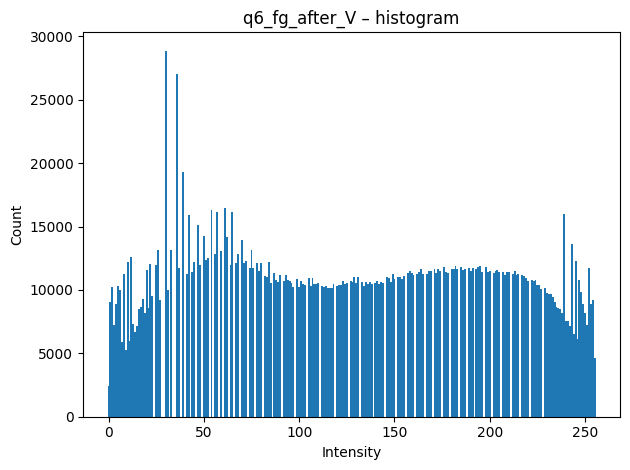

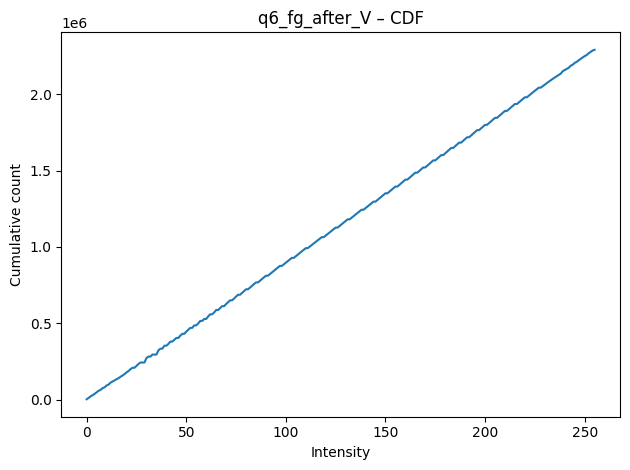

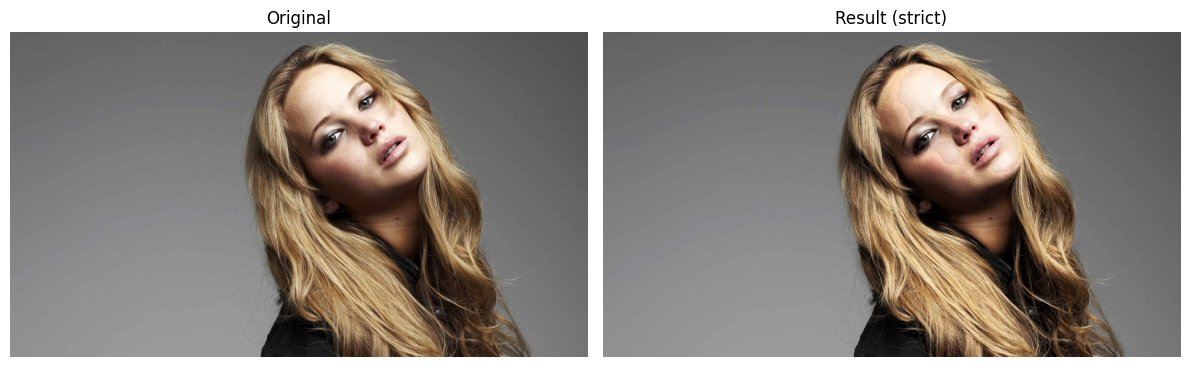

True

In [ ]:
# ---------------- display helpers ----------------
def show_gray_row(imgs, titles, figsize=(12,4)):
    fig, ax = plt.subplots(1, len(imgs), figsize=figsize)
    if len(imgs) == 1: ax = [ax]
    for a, im, t in zip(ax, imgs, titles):
        a.imshow(im, cmap='gray', vmin=0, vmax=255); a.set_title(t); a.axis('off')
    plt.tight_layout(); plt.show()

def save_hsv_and_mask(H, S, V, mask, out_dir="./Output_Images"):
    os.makedirs(out_dir, exist_ok=True)
    # Save HSV planes as one figure
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    for a, plane, title in zip(ax, [H,S,V], ["Hue","Saturation","Value"]):
        a.imshow(plane, cmap='gray', vmin=0, vmax=255); a.set_title(title); a.axis('off')
    plt.tight_layout()
    plt.savefig(f"{out_dir}/q6_hsv_planes.png", dpi=200, bbox_inches="tight")
    plt.close()
    # Save mask
    cv2.imwrite(f"{out_dir}/q6_mask.png", mask)

def save_hist_and_cdf(img_gray, mask, base, out_dir="./Output_Images", show=True):
    os.makedirs(out_dir, exist_ok=True)
    xs = np.arange(256)
    # Histogram with mask
    h = cv2.calcHist([img_gray],[0],mask,[256],[0,256]).ravel()
    fig, ax = plt.subplots()
    ax.bar(xs, h, width=1.0)
    ax.set_title(f"{base} – histogram"); ax.set_xlabel("Intensity"); ax.set_ylabel("Count")
    fig.tight_layout(); fig.savefig(f"{out_dir}/{base}_hist.png", dpi=200, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)
    # CDF
    c = np.cumsum(h)
    fig, ax = plt.subplots()
    ax.plot(xs, c)
    ax.set_title(f"{base} – CDF"); ax.set_xlabel("Intensity"); ax.set_ylabel("Cumulative count")
    fig.tight_layout(); fig.savefig(f"{out_dir}/{base}_cdf.png", dpi=200, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)

# ---------------- (a)(b) mask from HSV ----------------
def build_mask_from_hsv(img_bgr, mask_plane='S', thresh='otsu', invert=False, show=True):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    if show:
        show_gray_row([H, S, V], ["Hue","Saturation","Value"])
    P = {'H':H, 'S':S, 'V':V}[mask_plane.upper()]
    if thresh == 'otsu':
        _, mask = cv2.threshold(P, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        T = int(thresh); _, mask = cv2.threshold(P, T, 255, cv2.THRESH_BINARY)
    if invert: mask = cv2.bitwise_not(mask)
    # light clean-up
    k = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=1)
    if show:
        show_gray_row([mask], [f"Mask from {mask_plane}"])
    return mask, (H,S,V)

# ---------------- (c)(d)(e)(f) equalize FG only ----------------
def equalize_foreground_strict(img_bgr, mask, H, S, V, out_dir="./Output_Images", show=True):
    os.makedirs(out_dir, exist_ok=True)

    # (c) Foreground hist on V (and (d) its CDF) - BEFORE
    save_hist_and_cdf(V, mask, base="q6_fg_before_V", out_dir=out_dir, show=show)

    # CDF from FG only
    hist_fg = cv2.calcHist([V],[0],mask,[256],[0,256]).ravel()
    if hist_fg.sum() == 0:
        return img_bgr.copy()
    cdf = np.cumsum(hist_fg)
    cdf_min = cdf[cdf > 0][0]; N = cdf[-1]
    lut = np.round((cdf - cdf_min) / max(1,(N - cdf_min)) * 255.0).clip(0,255).astype(np.uint8)

    # Apply to V, then extract FG and BG, and add (as required)
    V_eq_all = cv2.LUT(V, lut)
    fg_eq    = cv2.bitwise_and(V_eq_all, V_eq_all, mask=mask)          # FG equalized
    bg_orig  = cv2.bitwise_and(V,        V,        mask=cv2.bitwise_not(mask))  # BG original
    V_out    = cv2.add(fg_eq, bg_orig)

    # (c)(d) AFTER hist + CDF on FG
    save_hist_and_cdf(V_out, mask, base="q6_fg_after_V", out_dir=out_dir, show=show)

    out_bgr = cv2.cvtColor(cv2.merge([H, S, V_out]), cv2.COLOR_HSV2BGR)
    return out_bgr

# ---------------- run on Fig.6 ----------------
img_path = "./a1images/jeniffer.jpg"   # <-- use this spelling as you prefer
img      = cv2.imread(img_path); assert img is not None, "Check Q6 image path"

# (a)(b) mask from S with Otsu
mask, (H,S,V) = build_mask_from_hsv(img, mask_plane='S', thresh='otsu', invert=False, show=True)

# Save HSV planes and mask (for the report)
save_hsv_and_mask(H, S, V, mask, out_dir="./Output_Images")

# (c)-(f) equalize FG only and recombine
result_strict = equalize_foreground_strict(img, mask, H, S, V, out_dir="./Output_Images", show=True)

# Show original vs result
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));           ax[0].set_title("Original");        ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(result_strict, cv2.COLOR_BGR2RGB));  ax[1].set_title("Result (strict)"); ax[1].axis('off')
plt.tight_layout(); plt.show()

# Save originals/results (for LaTeX)
os.makedirs("./Output_Images", exist_ok=True)
cv2.imwrite("./Output_Images/q6_original.png", img)
cv2.imwrite("./Output_Images/q6_result_strict.png", result_strict)


### Question 07 - Sobel filtering

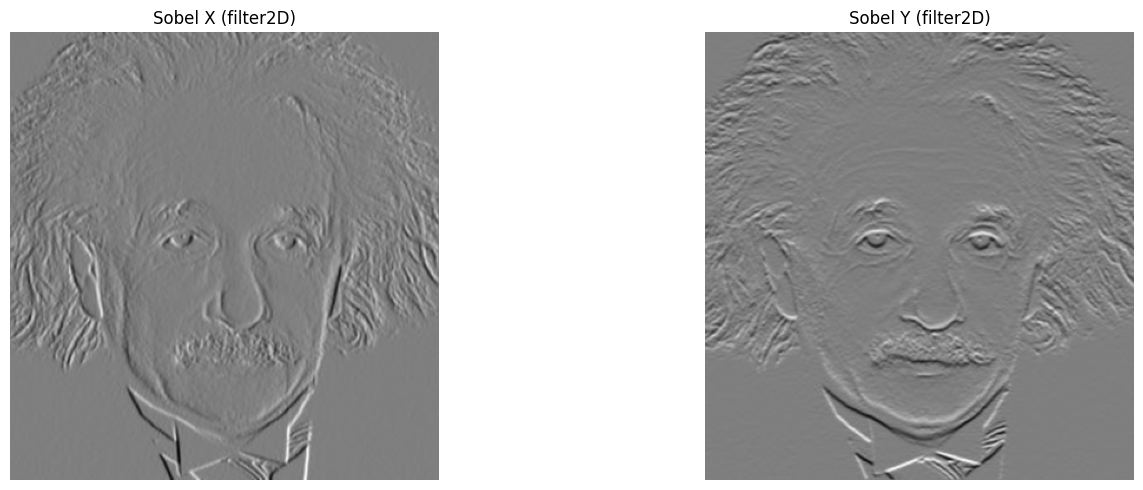

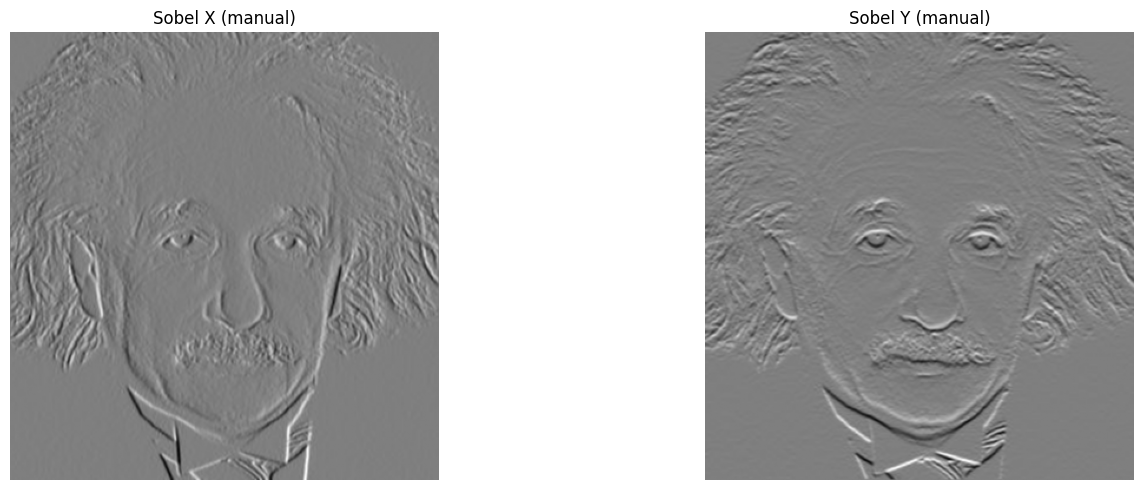

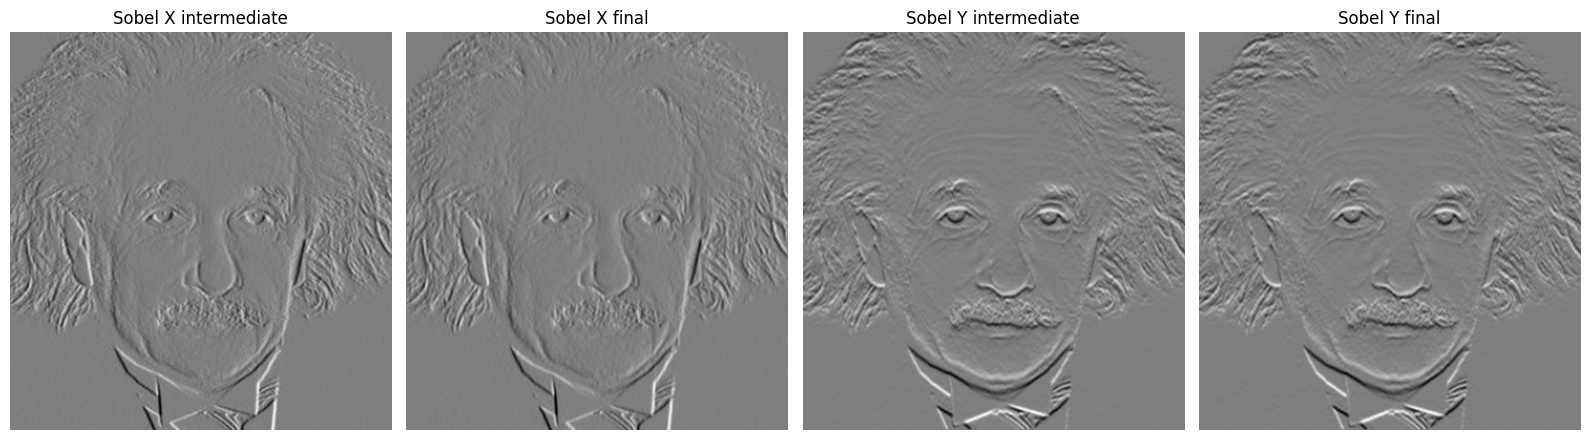

Saved: Output_Images/q7_conv_compare_row.png


In [72]:
import cv2, numpy as np, matplotlib.pyplot as plt, os

# ---- helpers ----
def imread_gray(p):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None: raise FileNotFoundError(p)
    return img

def show_row(imgs, titles, figsize=(16,5)):
    fig, ax = plt.subplots(1, len(imgs), figsize=figsize)
    if len(imgs)==1: ax=[ax]
    for a, im, t in zip(ax, imgs, titles):
        a.imshow(im, cmap='gray', vmin=0, vmax=255); a.set_title(t); a.axis('off')
    plt.tight_layout(); plt.show()

def to_uint8_signed(g):
    """Map signed float32 response to 0..255 with 0 mapped to 128."""
    m = float(np.max(np.abs(g))) + 1e-9
    return np.clip((g / (2*m) + 0.5) * 255.0, 0, 255).astype(np.uint8)

# Sobel kernels
Kx = np.array([[ 1, 0,-1],
               [ 2, 0,-2],
               [ 1, 0,-1]], dtype=np.float32)
Ky = Kx.T

# ---- (a) Sobel via filter2D ----
def sobel_filter2d_signed(img):
    gx = cv2.filter2D(img, cv2.CV_32F, Kx, borderType=cv2.BORDER_REFLECT)
    gy = cv2.filter2D(img, cv2.CV_32F, Ky, borderType=cv2.BORDER_REFLECT)
    return to_uint8_signed(gx), to_uint8_signed(gy)

# ---- (b) Manual convolution ----
def conv2d(img, k, border=cv2.BORDER_REFLECT):
    kh, kw = k.shape
    ph, pw = kh//2, kw//2
    pad = cv2.copyMakeBorder(img, ph, ph, pw, pw, border)
    out = np.zeros(img.shape, dtype=np.float32)
    k = k.astype(np.float32)
    H, W = img.shape
    for y in range(H):
        for x in range(W):
            roi = pad[y:y+kh, x:x+kw].astype(np.float32)
            out[y,x] = np.sum(roi * k)
    return out

def sobel_manual_signed(img):
    gx = conv2d(img, Kx)
    gy = conv2d(img, Ky)
    return to_uint8_signed(gx), to_uint8_signed(gy)

# ---- (c) Separable Sobel with intermediate steps ----
# Kx = a @ b, Ky = Kx^T, where:
a = np.array([1,2,1], dtype=np.float32).reshape(-1,1)   # 3x1 smoothing
b = np.array([1,0,-1], dtype=np.float32).reshape(1,-1)  # 1x3 derivative

def sobel_separable_signed(img):
    # Gx: horizontal derivative then vertical smoothing
    dx = cv2.filter2D(img, cv2.CV_32F, b, borderType=cv2.BORDER_REFLECT)   # intermediate (derivative only)
    gx = cv2.filter2D(dx,  cv2.CV_32F, a, borderType=cv2.BORDER_REFLECT)

    # Gy: vertical derivative then horizontal smoothing
    dy = cv2.filter2D(img, cv2.CV_32F, a, borderType=cv2.BORDER_REFLECT)   # smoothing first (equivalent order)
    dy = cv2.filter2D(dy,  cv2.CV_32F, b.T, borderType=cv2.BORDER_REFLECT) # derivative vertically (b^T)
    gy = dy

    return to_uint8_signed(dx), to_uint8_signed(gx), to_uint8_signed(dy), to_uint8_signed(gy)

# ---- run ----
img_path = "./a1images/einstein.png"   # set to Fig.7
img = imread_gray(img_path)

# (a)
gx_a, gy_a = sobel_filter2d_signed(img)
show_row([gx_a, gy_a], ["Sobel X (filter2D)", "Sobel Y (filter2D)"])

# (b)
gx_b, gy_b = sobel_manual_signed(img)
show_row([gx_b, gy_b], ["Sobel X (manual)", "Sobel Y (manual)"])

# (c)
dx, gx_c, dy, gy_c = sobel_separable_signed(img)
show_row([dx, gx_c, dy, gy_c],
         ["Sobel X intermediate", "Sobel X final",
          "Sobel Y intermediate", "Sobel Y final"])

# optional save
os.makedirs("./Output_Images", exist_ok=True)
cv2.imwrite("./Output_Images/q7_gx_filter2d.png", gx_a)
cv2.imwrite("./Output_Images/q7_gy_filter2d.png", gy_a)
cv2.imwrite("./Output_Images/q7_gx_manual.png",   gx_b)
cv2.imwrite("./Output_Images/q7_gy_manual.png",   gy_b)
cv2.imwrite("./Output_Images/q7_dx_sep.png",      dx)
cv2.imwrite("./Output_Images/q7_gx_sep.png",      gx_c)
cv2.imwrite("./Output_Images/q7_dy_sep.png",      dy)
cv2.imwrite("./Output_Images/q7_gy_sep.png",      gy_c)

# ---- combine all four into one horizontal figure ----
import matplotlib.pyplot as plt
import os

os.makedirs("./Output_Images", exist_ok=True)

titles = [
    "Sobel Gx (filter2D)", "Sobel Gy (filter2D)",
    "Sobel Gx (custom)",   "Sobel Gy (custom)"
]
imgs = [gx_a, gy_a, gx_b, gy_b]

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for a, im, t in zip(ax, imgs, titles):
    a.imshow(im, cmap='gray', vmin=0, vmax=255)
    a.set_title(t, fontsize=9)
    a.axis('off')

plt.tight_layout()
fig.savefig("./Output_Images/q7_conv_compare_row.png", dpi=220, bbox_inches="tight")
plt.close(fig)
print("Saved: Output_Images/q7_conv_compare_row.png")



### Question 08 - Image zoom + nSSD check

In [70]:
import os, csv, cv2, numpy as np
from pathlib import Path

# ---------- zoomers that hit the exact target size ----------
def zoom_nn_to(img: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = img.shape[:2]
    sy, sx = H / h, W / w
    y2 = np.arange(H); x2 = np.arange(W)
    y  = np.clip(np.round((y2 + 0.5)/sy - 0.5).astype(int), 0, h-1)
    x  = np.clip(np.round((x2 + 0.5)/sx - 0.5).astype(int), 0, w-1)
    return img[y[:,None], x[None,:]] if img.ndim==2 else img[y[:,None], x[None,:], :]

def zoom_bilinear_to(img: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = img.shape[:2]
    sy, sx = H / h, W / w
    y2 = np.arange(H); x2 = np.arange(W)
    y  = (y2 + 0.5)/sy - 0.5; x = (x2 + 0.5)/sx - 0.5
    y0 = np.floor(y).astype(int); x0 = np.floor(x).astype(int)
    y1 = np.clip(y0 + 1, 0, h-1);  x1 = np.clip(x0 + 1, 0, w-1)
    y0 = np.clip(y0, 0, h-1);      x0 = np.clip(x0, 0, w-1)
    wy = (y - y0).astype(np.float32); wx = (x - x0).astype(np.float32)

    w00 = (1-wy)[:,None]*(1-wx)[None,:]
    w01 = (1-wy)[:,None]*wx[None,:]
    w10 = wy[:,None]*(1-wx)[None,:]
    w11 = wy[:,None]*wx[None,:]

    if img.ndim == 2:
        I00 = img[y0[:,None], x0[None,:]].astype(np.float32)
        I01 = img[y0[:,None], x1[None,:]].astype(np.float32)
        I10 = img[y1[:,None], x0[None,:]].astype(np.float32)
        I11 = img[y1[:,None], x1[None,:]].astype(np.float32)
        out = I00*w00 + I01*w01 + I10*w10 + I11*w11
    else:
        I00 = img[y0[:,None], x0[None,:], :].astype(np.float32)
        I01 = img[y0[:,None], x1[None,:], :].astype(np.float32)
        I10 = img[y1[:,None], x0[None,:], :].astype(np.float32)
        I11 = img[y1[:,None], x1[None,:], :].astype(np.float32)
        out = (I00*w00[...,None] + I01*w01[...,None] +
               I10*w10[...,None] + I11*w11[...,None])

    return np.clip(out, 0, 255).astype(img.dtype)

def nssd(a: np.ndarray, b: np.ndarray) -> float:
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: {a.shape} vs {b.shape}")
    a32, b32 = a.astype(np.float32), b.astype(np.float32)
    return float(np.sum((a32 - b32)**2) / (np.sum(b32**2) + 1e-9))

# ---------- paths & pairs ----------
image_dir = Path("./a1images/a1q5images")
pairs = [
    ("im01small.png", "im01.png"),
    ("im02small.png", "im02.png"),
    ("im03small.png", "im03.png"),
    # "taylor_small.jpg" is ~5×; skip for the 4× requirement
]

csv_path = image_dir / "q8_nssd_results.csv"
rows = [("small_file", "large_file", "target_scale", "nSSD_NN", "nSSD_Bilinear")]

# Only accept scales ~ 4×
TARGET = 4.0
RTOL = 0.02  # ±2%

# ---------- run ----------
for small_name, large_name in pairs:
    sp = image_dir / small_name
    lp = image_dir / large_name
    small = cv2.imread(str(sp), cv2.IMREAD_COLOR)
    large = cv2.imread(str(lp), cv2.IMREAD_COLOR)
    assert small is not None and large is not None, f"Missing: {sp} or {lp}"

    hS, wS = small.shape[:2]
    hL, wL = large.shape[:2]
    sy, sx = hL / hS, wL / wS

    if not (np.isclose(sy, TARGET, rtol=RTOL) and np.isclose(sx, TARGET, rtol=RTOL)):
        print(f"[SKIP] {small_name}->{large_name} is ~({sy:.2f}×,{sx:.2f}×), not ≈ {TARGET:.2f}×.")
        continue

    up_nn = zoom_nn_to(small, hL, wL)
    up_bl = zoom_bilinear_to(small, hL, wL)

    nn = nssd(up_nn, large)
    bl = nssd(up_bl, large)
    print(f"{small_name} -> {large_name}  target≈{TARGET:.2f}x   nSSD  NN={nn:.6f}  Bilinear={bl:.6f}")

    base = Path(small_name).stem
    tag  = f"{TARGET:.2f}x"
    cv2.imwrite(str(image_dir / f"{base}_up_{tag}_NN.png"), up_nn)
    cv2.imwrite(str(image_dir / f"{base}_up_{tag}_Bilinear.png"), up_bl)

    rows.append((small_name, large_name, f"{TARGET:.2f}", f"{nn:.8f}", f"{bl:.8f}"))

with open(csv_path, "w", newline="") as f:
    csv.writer(f).writerows(rows)

print(f"\nSaved upscaled images and results CSV to: {image_dir}")
print(f"Results file: {csv_path.name}")


im01small.png -> im01.png  target≈4.00x   nSSD  NN=0.012058  Bilinear=0.010187
im02small.png -> im02.png  target≈4.00x   nSSD  NN=0.004190  Bilinear=0.002915
im03small.png -> im03.png  target≈4.00x   nSSD  NN=0.007530  Bilinear=0.005634

Saved upscaled images and results CSV to: a1images\a1q5images
Results file: q8_nssd_results.csv


### Question 9 -  GrabCut segmentation & background blur

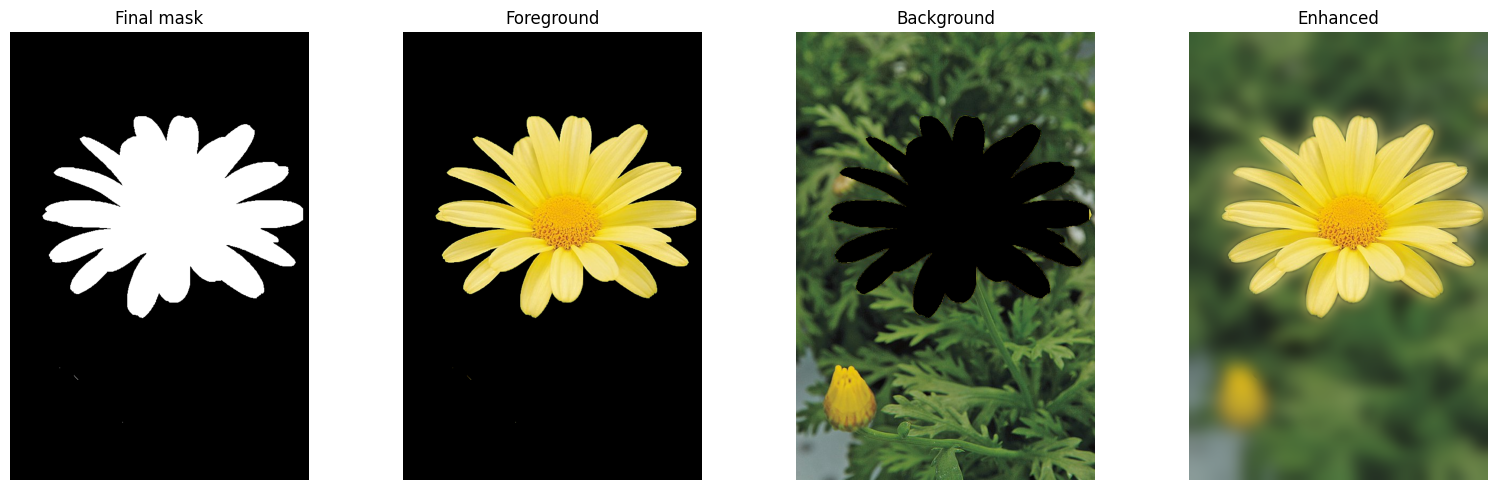

True

In [65]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- load ----
img = cv.imread("./a1images/daisy.jpg")  
assert img is not None
h, w = img.shape[:2]

# ---- (a) GrabCut: seed only the big flower ----
# Start with "probable background" everywhere
mask = np.full((h, w), cv.GC_PR_BGD, np.uint8)

# Sure background at image margins (prevents edge leaks)
m = int(0.02 * min(h, w))
mask[:m, :] = mask[-m:, :] = mask[:, :m] = mask[:, -m:] = cv.GC_BGD

# Probable foreground: a loose ellipse over the *big* flower
center = (int(0.55*w), int(0.36*h))
axes   = (int(0.33*w), int(0.28*h))   # tweak if needed
cv.ellipse(mask, center, axes, 0, 0, 360, cv.GC_PR_FGD, -1)

# Sure background: the small bud area (force it out)
bx0, by0 = int(0.08*w), int(0.78*h)
bx1, by1 = int(0.30*w), int(0.95*h)
cv.rectangle(mask, (bx0, by0), (bx1, by1), cv.GC_BGD, -1)

# Run GrabCut with the mask seeds
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)
cv.grabCut(img, mask, None, bgModel, fgModel, 5, cv.GC_INIT_WITH_MASK)

# Final binary mask: FG or Prob-FG
mask_fg = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype(np.uint8)
mask_bg = cv.bitwise_not(mask_fg)

# Foreground and background images
fg = cv.bitwise_and(img, img, mask=mask_fg)
bg = cv.bitwise_and(img, img, mask=mask_bg)

# ---- (b) Enhanced image: blur BG and feather edges ----
blurred = cv.GaussianBlur(img, (0, 0), 15)
alpha = cv.GaussianBlur(mask_fg, (0, 0), 3).astype(np.float32) / 255.0
enhanced = (img.astype(np.float32) * alpha[..., None] +
            blurred.astype(np.float32) * (1.0 - alpha[..., None]))
enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

# ---- visuals ----
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
ax[0].imshow(mask_fg, cmap='gray');                      ax[0].set_title("Final mask"); ax[0].axis('off')
ax[1].imshow(cv.cvtColor(fg, cv.COLOR_BGR2RGB));         ax[1].set_title("Foreground"); ax[1].axis('off')
ax[2].imshow(cv.cvtColor(bg, cv.COLOR_BGR2RGB));         ax[2].set_title("Background"); ax[2].axis('off')
ax[3].imshow(cv.cvtColor(enhanced, cv.COLOR_BGR2RGB));   ax[3].set_title("Enhanced");   ax[3].axis('off')
plt.tight_layout(); plt.show()

# ---- save (optional) ----
os.makedirs("./Output_Images", exist_ok=True)
cv.imwrite("./Output_Images/q9_mask_bigflower.png", mask_fg)
cv.imwrite("./Output_Images/q9_fg_bigflower.png", fg)
cv.imwrite("./Output_Images/q9_bg_bigflower.png", bg)
cv.imwrite("./Output_Images/q9_enhanced_bigflower.png", enhanced)
